# GRU Implementation

In [1]:
# --- we are doing GRU neural network ---
import torch                # pytorch
import torch.nn as nn       # neural network
import torch.optim as optim # optimizer
from torch.utils.data import DataLoader
# progress bars
from tqdm import tqdm
# summary
from torchinfo import summary
# --- end of imports ---

In [2]:
# cuda or mps or cpu for acceleration
if torch.cuda.is_available():
    device = torch.device("cuda") # nvidia gpu
elif torch.backends.mps.is_available(): 
    device = torch.device("mps") # apple silicon
else:                                 
    device = torch.device("cpu") # cpu

print("Device: ", device)

Device:  mps


In [3]:
# split data into training and testing
def train_vali_test_split(data, labels, train=0.8, vali=0.1, test=0.1):
    assert train + vali + test == 1, "train, vali, test must sum to 1"
    total = len(data)

    indices = torch.randperm(total)
    train_end = int(total * train)
    vali_end = int(total * (train + vali))

    train_indices = indices[:train_end]
    vali_indices = indices[train_end:vali_end]
    test_indices = indices[vali_end:]

    train_data = data[train_indices]
    train_labels = labels[train_indices]
    vali_data = data[vali_indices]
    vali_labels = labels[vali_indices]

    test_data = data[test_indices]
    test_labels = labels[test_indices]

    print("Training data: ", len(train_data))
    print("Validation data: ", len(vali_data))
    print("Testing data: ", len(test_data))

    return train_data, train_labels, vali_data, vali_labels, test_data, test_labels

In [4]:
class GRUNet(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(GRUNet, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        # initialize hidden state
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)

        out, _ = self.gru(x, h0)

        # decode the hidden state of the last time step
        out = self.fc(out[:, -1, :])
        return out

In [5]:
# class LSTMNet(nn.Module): # this may need to be changed and more steps for data loading
#     def __init__(self, input_size, hidden_size, num_layers, output_size):
#         super(LSTMNet, self).__init__()
#         self.hidden_size = hidden_size
#         self.num_layers = num_layers
#         self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
#         self.fc = nn.Linear(hidden_size, output_size)
    
#     def forward(self, x):
#         # initialize hidden state
#         h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
#         c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
#         # forward
#         out, _ = self.lstm(x, (h0, c0))

#         # decode the hidden state of the last time step
#         out = self.fc(out[:, -1, :])
#         return out

In [6]:
# data
NUM_EEG_CHANNELS = 64
NUM_JOINT_ANGLES = 6

# array of eeg as data
eeg_data = torch.randn(100, 100, NUM_EEG_CHANNELS).to(device)
# array of joint angles as labels (or velocity)
joint_angles = torch.randn(100, NUM_JOINT_ANGLES).to(device)

# check dimensions
print(eeg_data.dim())
print(joint_angles.dim())

3
2


In [8]:
input_size = NUM_EEG_CHANNELS # input size - number of eeg channels
hidden_size = 128 # hidden layer size - what we want to learn
output_size = NUM_JOINT_ANGLES # output size - number of joint angles / features
num_layers = 1 # number of layers
batch_size = 16 # batch size

model = GRUNet(input_size, hidden_size, num_layers=num_layers, output_size=output_size)
model.to(device)

print(model)

GRUNet(
  (gru): GRU(64, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=6, bias=True)
)


In [9]:
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss() # mean squared error loss function

## Training Loop

In [10]:
epochs = 20


train_data, train_labels, vali_data, vali_labels, test_data, test_labels = train_vali_test_split(eeg_data, joint_angles)

# dataloader
train_dataset = torch.utils.data.TensorDataset(train_data, train_labels)
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)

vali_dataset = torch.utils.data.TensorDataset(vali_data, vali_labels)
vali_loader = DataLoader(dataset=vali_dataset, batch_size=batch_size, shuffle=False)

Training data:  80
Validation data:  10
Testing data:  10


In [11]:
for inputs, labels in train_loader:
    print(f"Inputs shape: {inputs.shape}, Labels shape: {labels.shape}")
    break  # Just print the first batch to check

Inputs shape: torch.Size([16, 100, 64]), Labels shape: torch.Size([16, 6])


In [13]:
train_loss_arr = []
vali_loss_arr = []

for epoch in range(epochs):
    model.train()
    total_train_loss = 0
    total_vali_loss = 0
    num_train_batches = 0
    num_vali_batches = 0

    for i, data in enumerate(tqdm(train_loader)):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_train_loss += loss.item()
        num_train_batches += 1

    avg_train_loss = total_train_loss / num_train_batches if num_train_batches > 0 else 0
    train_loss_arr.append(avg_train_loss)

    model.eval()
    with torch.no_grad():
        for i, data in enumerate(tqdm(vali_loader)):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            total_vali_loss += loss.item()
            num_vali_batches += 1

    avg_vali_loss = total_vali_loss / num_vali_batches if num_vali_batches > 0 else 0
    vali_loss_arr.append(avg_vali_loss)

    print(f"Epoch {epoch+1}/{epochs} - Train Loss: {avg_train_loss:.4f} - Vali Loss: {avg_vali_loss:.4f}")

100%|██████████| 1/1 [00:00<00:00, 36.95it/s]


Epoch 1/20 - Train Loss: 0.0240 - Vali Loss: 1.7302


100%|██████████| 1/1 [00:00<00:00, 38.38it/s]


Epoch 2/20 - Train Loss: 0.0158 - Vali Loss: 1.7447


100%|██████████| 1/1 [00:00<00:00, 37.43it/s]


Epoch 3/20 - Train Loss: 0.0105 - Vali Loss: 1.7404


100%|██████████| 1/1 [00:00<00:00, 36.85it/s]


Epoch 4/20 - Train Loss: 0.0067 - Vali Loss: 1.7407


100%|██████████| 1/1 [00:00<00:00, 37.30it/s]


Epoch 5/20 - Train Loss: 0.0043 - Vali Loss: 1.7448


100%|██████████| 1/1 [00:00<00:00, 35.92it/s]


Epoch 6/20 - Train Loss: 0.0026 - Vali Loss: 1.7480


100%|██████████| 1/1 [00:00<00:00, 35.03it/s]


Epoch 7/20 - Train Loss: 0.0016 - Vali Loss: 1.7444


100%|██████████| 1/1 [00:00<00:00, 35.32it/s]


Epoch 8/20 - Train Loss: 0.0010 - Vali Loss: 1.7390


100%|██████████| 1/1 [00:00<00:00, 34.79it/s]


Epoch 9/20 - Train Loss: 0.0006 - Vali Loss: 1.7377


100%|██████████| 1/1 [00:00<00:00, 37.71it/s]


Epoch 10/20 - Train Loss: 0.0004 - Vali Loss: 1.7375


100%|██████████| 1/1 [00:00<00:00, 34.68it/s]


Epoch 11/20 - Train Loss: 0.0002 - Vali Loss: 1.7365


100%|██████████| 1/1 [00:00<00:00, 36.95it/s]


Epoch 12/20 - Train Loss: 0.0001 - Vali Loss: 1.7369


100%|██████████| 1/1 [00:00<00:00, 36.42it/s]


Epoch 13/20 - Train Loss: 0.0001 - Vali Loss: 1.7375


100%|██████████| 1/1 [00:00<00:00, 33.81it/s]


Epoch 14/20 - Train Loss: 0.0000 - Vali Loss: 1.7364


100%|██████████| 1/1 [00:00<00:00, 37.35it/s]


Epoch 15/20 - Train Loss: 0.0000 - Vali Loss: 1.7359


100%|██████████| 1/1 [00:00<00:00, 34.97it/s]


Epoch 16/20 - Train Loss: 0.0000 - Vali Loss: 1.7360


100%|██████████| 1/1 [00:00<00:00, 35.88it/s]


Epoch 17/20 - Train Loss: 0.0000 - Vali Loss: 1.7360


100%|██████████| 1/1 [00:00<00:00, 37.92it/s]


Epoch 18/20 - Train Loss: 0.0000 - Vali Loss: 1.7355


100%|██████████| 1/1 [00:00<00:00, 36.52it/s]


Epoch 19/20 - Train Loss: 0.0000 - Vali Loss: 1.7353


100%|██████████| 1/1 [00:00<00:00, 36.24it/s]

Epoch 20/20 - Train Loss: 0.0000 - Vali Loss: 1.7352


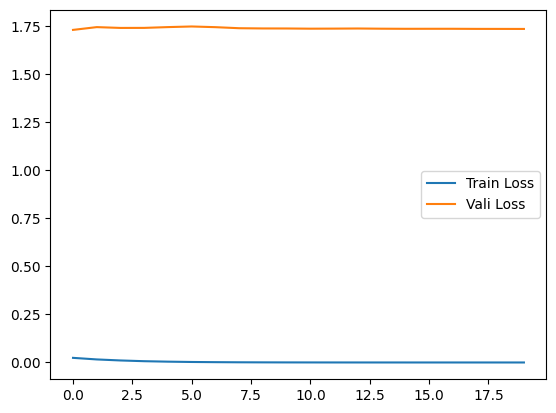

In [14]:
# plot the loss
import matplotlib.pyplot as plt
plt.plot(train_loss_arr, label="Train Loss")
plt.plot(vali_loss_arr, label="Vali Loss")
plt.legend()
plt.show()